# MADS: Model diagnostics

[MADS](http://madsjulia.github.io/Mads.jl) is an integrated high-performance computational framework for data/model/decision analyses.

<div style="text-align: left; padding-top: 30px; padding-bottom: 30px;">
    <img src="https://raw.githubusercontent.com/madsjulia/Mads.jl/master/logos/mads_black_swan_logo_big_text_new_3inch.png" alt="MADS" width=20% max-width=125px;/>
</div>

[MADS](http://madsjulia.github.io/Mads.jl) can be applied to perform:

* Sensitivity Analysis
* Parameter Estimation
* Model Inversion and Calibration
* Uncertainty Quantification
* Model Selection and Model Averaging
* Model Reduction and Surrogate Modeling
* Machine Learning (e.g., Blind Source Separation, Source Identification, Feature Extraction, Matrix / Tensor Factorization, etc.)
* Decision Analysis and Support

Here, it is demonstrated how [MADS](http://madsjulia.github.io/Mads.jl) can be applied to solve a general model diagnostic problem.

Most of the tasks listed above are demonstrated below.

## Problem setup

Import Mads (if **MADS** is not installed, first execute in the Julia REPL): 

```julia
import Pkg
Pkg.add("Mads")
```

In [1]:
import Mads

Setup the working directory (in this case, the working directory is the location of this notebook):

In [2]:
cd(joinpath(Mads.dir, "notebooks", "model_diagnostics"))

### Setup the model:

A function (called `polynomial`) is defined to compute the 6 observations given the 4 model parameters as an input:

In [3]:
function polynomial(parameters::AbstractVector)
	f(t) = parameters[1] * (t ^ parameters[4]) + parameters[2] * t + parameters[3] # a * t^n + b * t + c
	predictions = map(f, 0:5)
	return predictions
end

polynomial (generic function with 1 method)

This function will be applied in the model diagnostics analyses presented here.

We can execute `polynomial()` for a vector of 4 inputs such as `[3, 2, 3, 4]`:

In [4]:
polynomial([3, 2, 3, 4])


6-element Vector{Float64}:
 0.32559787075663094
 1.7000988282007747
 2.508338211857952
 3.2597065056645955
 3.9839897192155456
 4.691889957985813

### Setup the problem dictionary (method #1)

A problem dictionary is applied to store all the information related to the analyzed model.

This includes:
* parameter names (`["a", "b", "c", "n"]`)
* parameter initial guesses (`[1,1,1,1]`)
* parameter prior distributions
* true observation values that we want to reproduce (`[0,1.1,1.9,3.1,3.9,5]`)
* observation distributions (i.e., uncertainty ranges or measurement errors)
* observation weights (`[100,100,100,100,10,0]`)
* observation times (`[0,1,2,3,4,5]`) at which observations are made

The problem dictionary is created as follows:

In [4]:
md = Mads.createproblem([1,1,1,1], [0,1.1,1.9,3.1,3.9,5], polynomial; paramkey=["a", "b", "c", "n"], paramdist=["Uniform(-10, 10)", "Uniform(-10, 10)", "Uniform(-5, 5)", "Uniform(0, 3)"], obsweight=[100,100,100,100,10,0], obstime=[0,1,2,3,4,5], obsdist=["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"], problemname="model_diagnostics")

Dict{Any, Any} with 4 entries:
  "Julia function" => polynomial
  "Parameters"     => OrderedCollections.OrderedDict{Any, Any}("a"=>OrderedColl…
  "Observations"   => OrderedCollections.OrderedDict{Any, Any}("o1"=>OrderedCol…
  "Filename"       => "model_diagnostics.mads"

### Setup the problem dictionary (method #2)

The same problem dictionary can be created in a step-by-step fashion which is slightly more explicit.

#### Setup empty dictionary:

In [5]:
md = Dict()

Dict{Any, Any}()

#### Setup model parameters:

In [6]:
md["Parameters"] = Mads.createparameters([1,1,1,1]; key=["a", "b", "c", "n"], dist=["Uniform(-10, 10)", "Uniform(-10, 10)", "Uniform(-5, 5)", "Uniform(0, 3)"])

OrderedCollections.OrderedDict{Any, Any} with 4 entries:
  "a" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "b" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "c" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …
  "n" => OrderedCollections.OrderedDict{String, Any}("init"=>1, "type"=>"opt", …

There are 4 model parameters (`a`, `b`, `c`, and `n`).

The initial values and the prior distributions (based on prior knowledge of the parameter uncertainty) are defined for each parameter.

#### Setup model observations:

In [7]:
md["Observations"] = Mads.createobservations([0,1.1,1.9,3.1,3.9,5]; weight=[100,100,100,100,10,0], time=[0,1,2,3,4,5], dist=["Uniform(0, 1)", "Uniform(0, 2)", "Uniform(1, 3)", "Uniform(2, 4)", "Uniform(3, 5)", "Uniform(4, 6)"])

OrderedCollections.OrderedDict{Any, Any} with 6 entries:
  "o1" => OrderedCollections.OrderedDict{String, Any}("target"=>0.0, "weight"=>…
  "o2" => OrderedCollections.OrderedDict{String, Any}("target"=>1.1, "weight"=>…
  "o3" => OrderedCollections.OrderedDict{String, Any}("target"=>1.9, "weight"=>…
  "o4" => OrderedCollections.OrderedDict{String, Any}("target"=>3.1, "weight"=>…
  "o5" => OrderedCollections.OrderedDict{String, Any}("target"=>3.9, "weight"=>…
  "o6" => OrderedCollections.OrderedDict{String, Any}("target"=>5.0, "weight"=>…

There are 6 observations automatically labelled as (`o1`, `o2`, `o3`, ... and `o6`).

The observations are values that we want to reproduce with our model.

They can be also called calibration targets.

For each observation (calibration target), we specify observation weight (i.e., the inverse of measurement standard deviations).

Zero observation weight implies that the last observation is unknown (potentially occuring in the future) and will be estimated (predicted) by the developed model.

Acceptable ranges are defined for each observation representing.

#### Setup the model

The `polynomial` function is set up now in the `md` dictionary as a model that will be applied to perform the simulations:

In [8]:
Mads.setmodel!(md, polynomial)

(::Mads.var"#madscommandfunctionwithexpressions#18") (generic function with 1 method)

The analyzed model captured in the problem dictionary can be:
* analytical or numerical
* internal or external (e.g., PFLOTRAN, FEHM, or any other simulator)

The model can also be a reduced-order model developed using machine learning.

#### Set a default name for MADS input / output files:

In [9]:
md["Filename"] = "model_diagnostics.mads"

"model_diagnostics.mads"

Now, the problem dictionary `md` is fully defined:

In [10]:
display(md)

Dict{Any, Any} with 4 entries:
  "Julia function" => polynomial
  "Parameters"     => OrderedCollections.OrderedDict{Any, Any}("a"=>OrderedColl…
  "Observations"   => OrderedCollections.OrderedDict{Any, Any}("o1"=>OrderedCol…
  "Filename"       => "model_diagnostics.mads"

And the model diagnostic problem is set up!

We can also double check the problem setup.

In [11]:
Mads.showparameters(md)

a =               1 distribution = Uniform(-10, 10) 
b =               1 distribution = Uniform(-10, 10) 
c =               1 distribution = Uniform(-5, 5) 
n =               1 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


In [12]:
Mads.showobservations(md)

o1         target =               0 weight =             100
o2         target =             1.1 weight =             100
o3         target =             1.9 weight =             100
o4         target =             3.1 weight =             100
o5         target =             3.9 weight =              10
o6         target =               5 weight =               0
Number of observations is 6


## Forward model simulation

A single forward model run based on the initial model parameter values can be executed as follows:

In [13]:
Mads.forward(md)

OrderedCollections.OrderedDict{Any, Float64} with 6 entries:
  "o1" => 1.0
  "o2" => 3.0
  "o3" => 5.0
  "o4" => 7.0
  "o5" => 9.0
  "o6" => 11.0

The forward model run can also be executed using the following command:

In [14]:
polynomial(Mads.getparamsinit(md))

6-element Vector{Float64}:
  1.0
  3.0
  5.0
  7.0
  9.0
 11.0

The runs above produce outputs representing model predictions at the six observations over time.

The forward simulations are based on the initial guesses for the model parameters.

The initial model predictions look like this:

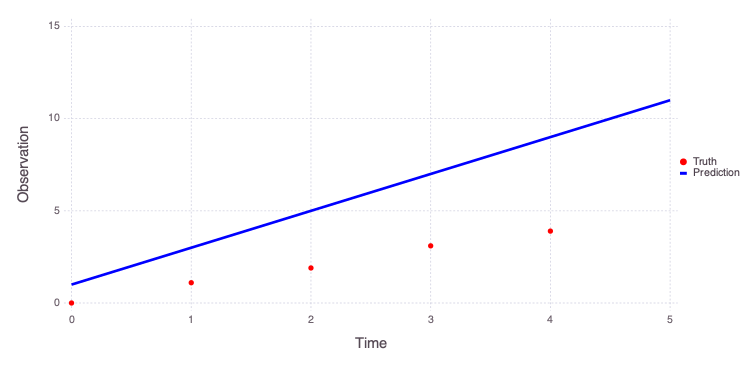

In [15]:
Mads.plotmatches(md)

The figure above shows that the `true` observations are not well reproduced by the model using the initial model parameter guesses.

## Model calibration (inversion)

The calibration (inversion) of the developed model is achieved using the following command:

In [16]:
calib_param, calib_information = Mads.calibrate(md)

(OrderedCollections.OrderedDict("a" => 0.0070504634932362364, "b" => 0.9506900793467459, "c" => 0.03854153288467277, "n" => 2.9321887287806576), OptimBase.MultivariateOptimizationResults{LsqFit.LevenbergMarquardt, Float64, 1}(LsqFit.LevenbergMarquardt(), [0.10016742116155988, 0.10016742116155988, 0.20135792079033074, -0.339836909454122], [-31.415221489490197, 31.51113933688991, 0.007708382914323126, 33.28855825149693], 233.37348475659584, 19, false, true, 0.0001, 0.0, false, 0.001, 0.0, false, 1.0e-6, 0.0, false, Iter     Function value   Gradient norm 
------   --------------   --------------
, 267, 19, 0))

The code returns 2 objects.

`calib_param` is a dictionary of the calibrated model parameters.

`calib_information` contains calibration information.

The obtained model predictions can be plotted:

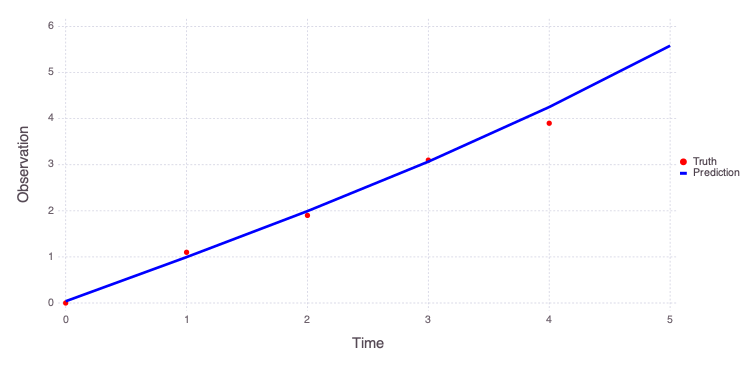

In [17]:
Mads.plotmatches(md, calib_param)

Initial values of the model parameters are:

In [18]:
Mads.showparameterestimates(md)

a =               1 distribution = Uniform(-10, 10) 
b =               1 distribution = Uniform(-10, 10) 
c =               1 distribution = Uniform(-5, 5) 
n =               1 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


Estimated values of the model parameters based on the model calibration (inversion) are:

In [19]:
Mads.showparameterestimates(md, calib_param)

a =      0.00705046 distribution = Uniform(-10, 10) 
b =         0.95069 distribution = Uniform(-10, 10) 
c =       0.0385415 distribution = Uniform(-5, 5) 
n =         2.93219 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


## Model calibration (inversion) for a set of random initial guesses

The model inversion can also be performed for a set of random initial guesses for model parameters.

In [20]:
calib_random_results = Mads.calibraterandom(md, 100; seed=2021, all=true)

100×3 Matrix{Any}:
  232.272  …  OrderedCollections.OrderedDict("a"=>0.00653517, "b"=>0.950689, "c"=>0.039249, "n"=>3.0)
  270.314     OrderedCollections.OrderedDict("a"=>-0.28542, "b"=>1.27948, "c"=>0.0178456, "n"=>0.951994)
  232.272     OrderedCollections.OrderedDict("a"=>0.00653398, "b"=>0.950704, "c"=>0.0392286, "n"=>3.0)
  232.272     OrderedCollections.OrderedDict("a"=>0.00653436, "b"=>0.950702, "c"=>0.0392321, "n"=>2.99998)
  232.272     OrderedCollections.OrderedDict("a"=>0.00653522, "b"=>0.950689, "c"=>0.039249, "n"=>3.0)
  270.097  …  OrderedCollections.OrderedDict("a"=>-4.30065, "b"=>5.28695, "c"=>0.0214167, "n"=>0.995285)
 7643.02      OrderedCollections.OrderedDict("a"=>-9.89624, "b"=>9.82224, "c"=>0.622939, "n"=>0.910639)
  269.91      OrderedCollections.OrderedDict("a"=>-4.41759, "b"=>5.40692, "c"=>0.0206894, "n"=>0.9961)
  270.093     OrderedCollections.OrderedDict("a"=>-4.82082, "b"=>5.80708, "c"=>0.0214349, "n"=>0.995788)
  270.067     OrderedCollections.OrderedDict(

The final parameter estimates from the 100 random-initial-guess inverse runs are collected into a matrix below:

In [21]:
calib_random_estimates = hcat(map(i->collect(values(calib_random_results[i,3])), 1:100)...)

4×100 Matrix{Float64}:
 0.00653517  -0.28542    0.00653398  …  0.962624   -5.46149    -0.387051
 0.950689     1.27948    0.950704       0.0219806   6.44768     1.37691
 0.039249     0.0178456  0.0392286      0.0223074   0.0214512   0.0197667
 3.0          0.951994   3.0            1.02225     0.996277    0.954846

Plot the final predictions of the 100 random-initial-guess inverse runs:

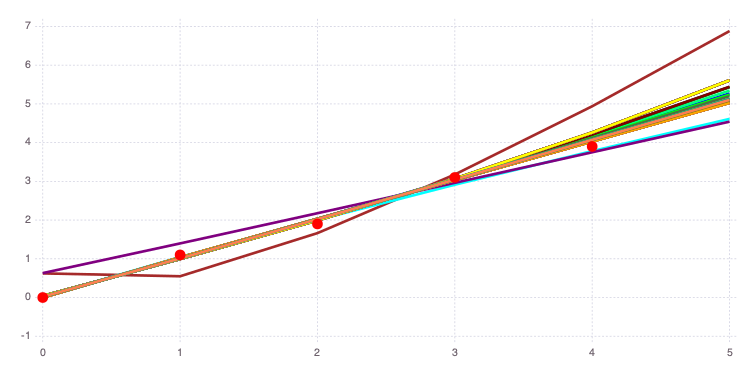

In [22]:
forward_predictions = Mads.forward(md, calib_random_estimates)
Mads.spaghettiplot(md, forward_predictions)

The results and figure above demonstrate that there are several different "global" minima.

There are three important groups of results with different `n` values:
* `n` = 0
* `n` = 1
* `n` = 3 (capturing the upper prior bound)

The code below identifies and plots solutions associated with these 3 distinct groups:

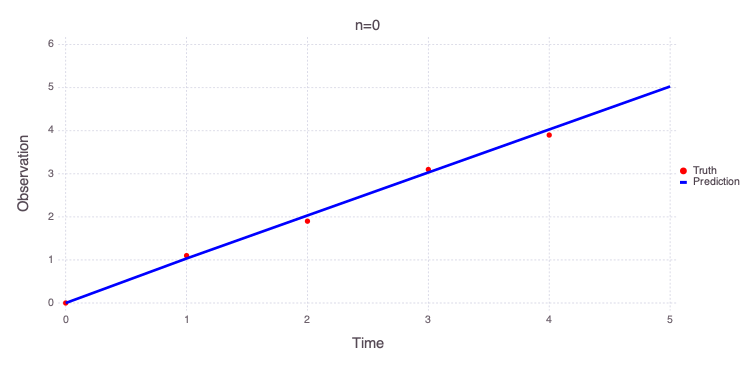

Solution for n=0
a =       0.0354613 distribution = Uniform(-10, 10) 
b =        0.998702 distribution = Uniform(-10, 10) 
c =     1.70238e-05 distribution = Uniform(-5, 5) 
n =     0.000376271 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


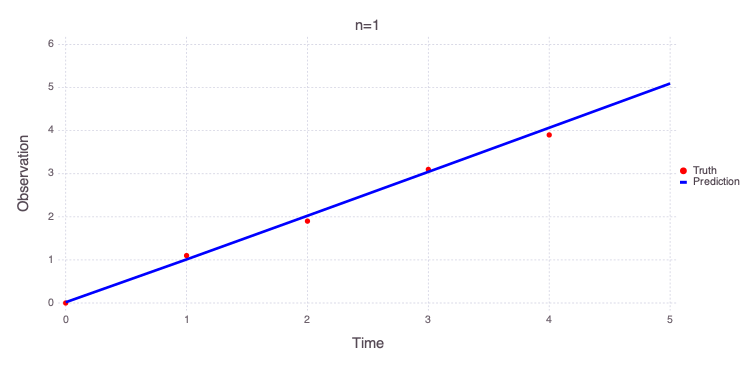

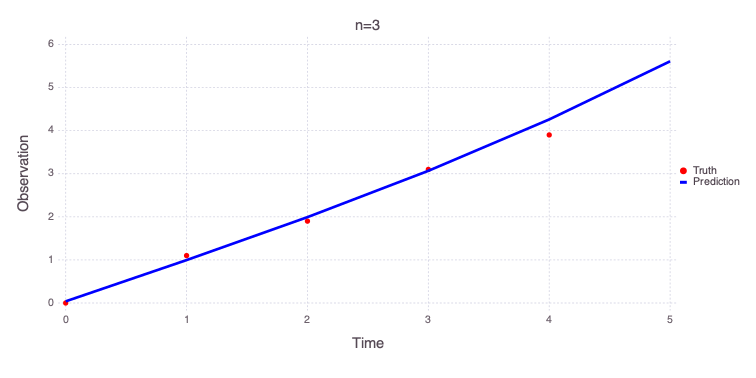

Solution for n=1
a =        -0.28542 distribution = Uniform(-10, 10) 
b =         1.27948 distribution = Uniform(-10, 10) 
c =       0.0178456 distribution = Uniform(-5, 5) 
n =        0.951994 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4
Solution for n=3
a =      0.00653517 distribution = Uniform(-10, 10) 
b =        0.950689 distribution = Uniform(-10, 10) 
c =        0.039249 distribution = Uniform(-5, 5) 
n =               3 distribution = Uniform(0, 3) 
Number of optimizable parameters: 4


In [23]:
ind_n0 = abs.(calib_random_estimates[4,:]) .< 0.1
in0 = findall(ind_n0 .== true)[1]
ind_n1 = abs.(calib_random_estimates[4,:] .- 1) .< 0.1
in1 = findall(ind_n1 .== true)[1]
ind_n3 = .!(ind_n0 .| ind_n1)
in3 = findall(ind_n3 .== true)[1]
pinit = Dict(zip(Mads.getparamkeys(md), Mads.getparamsinit(md)))
optnames = ["n=0", "n=1", "n=3"]
v = [in0, in1, in3]

for i = 1:3
	println("Solution for $(optnames[i])")
	Mads.showparameters(md, calib_random_results[v[i],3])
	Mads.plotmatches(md, calib_random_results[v[i],3]; title=optnames[i])
end

## Analysis of predictive sensitivities and uncertainties

### Local sensitivity and uncertainty quantification

In [24]:
localsa = Mads.localsa(md; filename="model_diagnostics.png", par=collect(values(calib_param)))

Dict{String, Any} with 6 entries:
  "of"          => 233.373
  "jacobian"    => [0.0 0.0 498.96 0.0; 998.299 989.063 498.96 0.0; … ; 5815.86…
  "covar"       => [9.60666e-7 -1.96149e-6 6.59975e-7 -0.00248792; -1.96149e-6 …
  "eigenmatrix" => [-0.99148 0.126137 0.0324964 0.000380915; -0.128081 -0.89869…
  "eigenvalues" => [1.36761e-9, 4.44737e-7, 4.31592e-6, 6.53143]
  "stddev"      => [0.000980135, 0.00217703, 0.00198921, 2.55567]

`localsa["stddev"]` defines the estimated posterior uncertainties in the estimated model parameters.

This estimate is based on the Jacobian / Hessian matrix estimates of the parameter space curvature in the vicinity of the estimated (inverted) optimal parameters.

The uncertainties are assumed to be Gaussian with standard deviations defined by `localsa["stddev"]`.

In [25]:
[Mads.getparamlabels(md) localsa["stddev"]]

4×2 Matrix{Any}:
 "a"  0.000980135
 "b"  0.00217703
 "c"  0.00198921
 "n"  2.55567

Based on these results, `c` is well constrained. `n` is also well defined. In contrast, `a` and `b` are less certain.

However, because of the local nature of the estimates, these results are not very accurate and differ with the global sensitivity and uncertainty analyses presented below.

The plots below show a series of graphical representations of the `localsa` results. 
These plots are generated automatically by the code.

A plot of the Jacobian representing the relationships between model parameters and estimated observations:

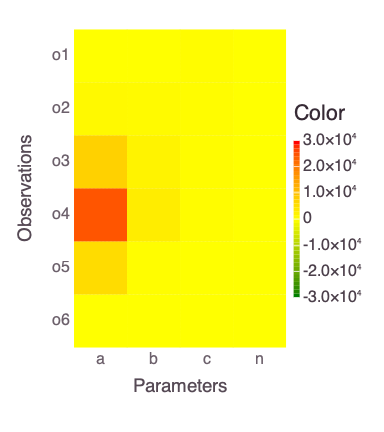

In [26]:
Mads.display("model_diagnostics-jacobian.png")

Based on the Jacobian matrix, `o4` is the observation most impacted by changes in parameter `a`.

A plot of the eigen matrix of the Hessian (the Hessian is approximately computed based on the Jacobian above):

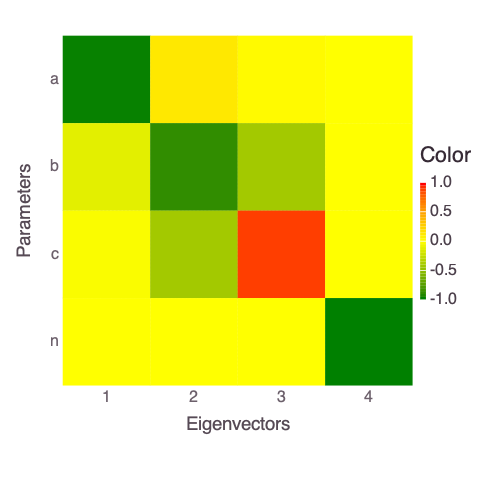

In [27]:
Mads.display("model_diagnostics-eigenmatrix.png")

A plot of the eigenvalues of the Hessian matrix:

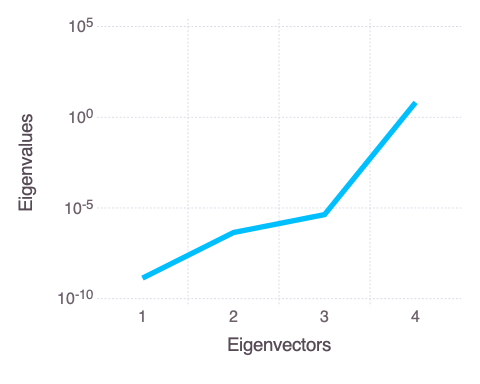

In [28]:
Mads.display("model_diagnostics-eigenvalues.png")

The eigen analysis presented above suggests that parameters `a` and `b` are correlated (this is expected based on the mathematical form of the solved model in the function `polynomial`).

Both parameters are represented by the first and the second eigenvectors.

Because, `a` and `b` are associated with eigenvectors with low eigenvalues, these parameters are also the most important.

Based on the eigen analysis, the order of parameter importance is: `a`, `b`, `c`, and `n`.

The parameter `n` in uncorrelated and independent of `a`, `b`, and `c`.

## Global sensitivity and uncertainty quantification

### Affine Invariant MCMC

Our module `AffineInvariantMCMC.jl` (aka `EMCEE`) is applied to perform global sensitivity and uncertainty quantification:

In [29]:
chain, llhoods = Mads.emceesampling(md; numwalkers=10, nsteps=100000, burnin=10000, thinning=10, seed=2016, sigma=0.01)

([0.49024400617534947 0.6254729606781848 … -8.046148738315333 -2.1961730184742825; 0.6481371331360766 0.5032929504742999 … 9.11821705704645 3.2649675439015318; -0.0892523408443533 -0.17549509446712216 … -0.02937423101178159 0.02857674237214133; 0.8301664734123894 0.9506210629622112 … 1.0109232316258625 1.0385261234145131], [-13.932168591704212, -17.348618201269236, -12.63389804512083, -13.91533166749997, -13.580439063638536, -12.966576797494277, -13.683861969420244, -12.759294163171537, -12.514264566232404, -13.004554415413187  …  -14.013608226665623, -13.538985556025008, -13.092064136134097, -14.227146487852597, -17.53945111529656, -13.317831924258758, -16.05995385278711, -12.536985011850854, -15.022418530804252, -13.952189155538974])

The results above capture 10,000 equally likely parameter combinations.

The parameter combintations represent the global sensitivity and uncertainty of the model parameters and associated predictions.

A forward run based on this set (`chain`) is executed below:

In [30]:
f = Mads.forward(md, chain)

6×10000 Matrix{Float64}:
 -0.0892523  -0.175495  0.0521224  …  -0.0309209  -0.0293742  0.0285767
  1.04913     0.953271  1.02412        1.00445     1.04269    1.09737
  2.07862     2.03995   2.00473        2.01825     1.99246    2.04729
  3.07556     3.11172   2.98858        3.02342     2.89541    2.95011
  4.05291     4.17404   3.97454        4.02286     3.76782    3.82182
  5.01641     5.22941   4.96206    …   5.01799     4.61745    4.67012

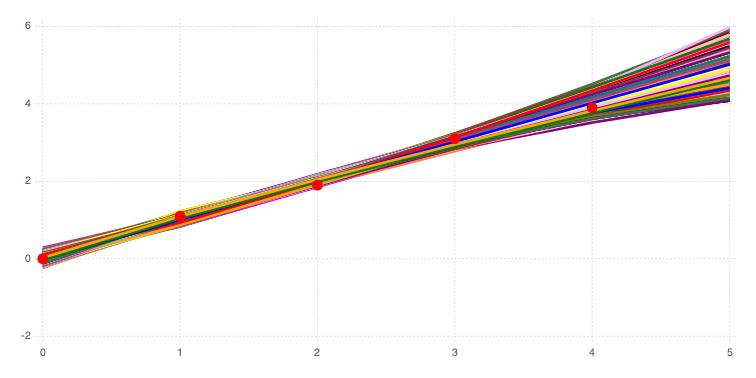

In [31]:
Mads.spaghettiplot(md, f)

The figure above compares the 10,000 model predictions with the actual measurements (red dots).

The figure below shows the histograms of the posterior model uncertainties (along the diagonal) and the cross-plots between the parameters (off-diagonal plots; the cross-plots above and below the diagonal are similar):

In [32]:
Mads.scatterplotsamples(md, permutedims(chain), "model_diagnostics-emcee_scatter.png")

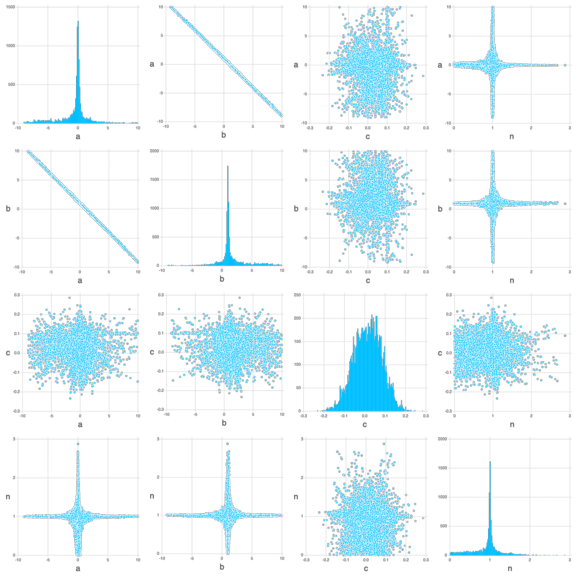

In [33]:
Mads.display("model_diagnostics-emcee_scatter.png")

The figure above shows that the optimal (most probable) estimates are:
* `a` = 0
* `b` = 1
* `c` = 0
* `n` = 0

`c` i the most constrained (varying between -0.2 and 0.2).

There are plausible solutions for any value of `a`, `b` and `n` within the prior uncertainty range.

The parameters `a` and `b` are strongly inversely correlated by their respective cross-plots.

Based on the cross-plots, the plausible values for `n` can be within the entire prior uncertainty range if (1) `a` is equal to 0 and (2) `b` is equal to 1.

The plausible values for `n` are close to 1 if (1) `a` is very different from 0 and (2) `b` is very different from 1.


### Saltelli (Sobol) and EFAST global sensitivity analyses

Both Saltelli (Sobol) and EFAST methods are producing similar results.

Both methods are designed to perform global sensitivity analyses.

EFAST is computationally more efficient.

The Saltelli (Sobol) results are obtained as follows:


In [34]:
saltelli_results = Mads.saltelli(md, N=10000, seed=2016)

Dict{String, Any} with 6 entries:
  "method"     => "saltelli"
  "samplesize" => 10000
  "mes"        => OrderedCollections.OrderedDict("o1"=>OrderedCollections.Order…
  "tes"        => OrderedCollections.OrderedDict("o1"=>OrderedCollections.Order…
  "seed"       => 2016
  "var"        => OrderedCollections.OrderedDict("o1"=>OrderedCollections.Order…

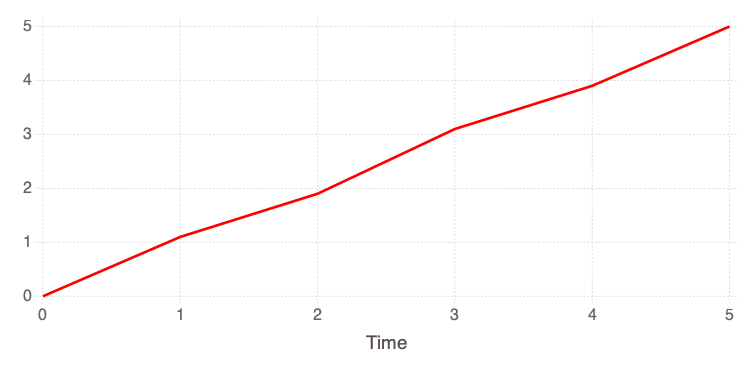

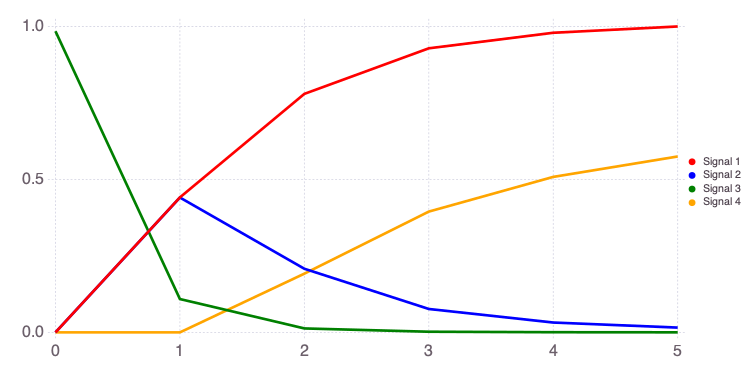

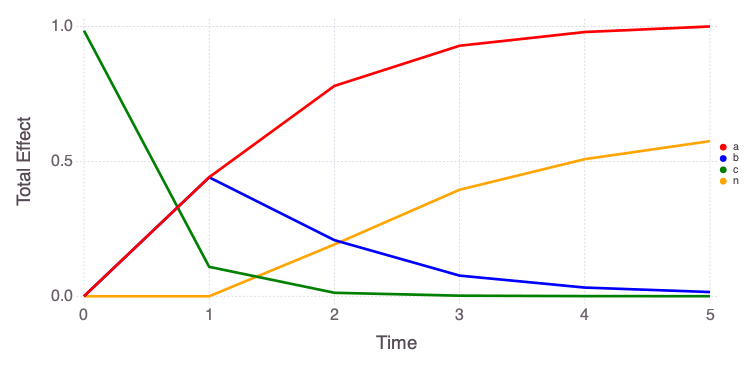

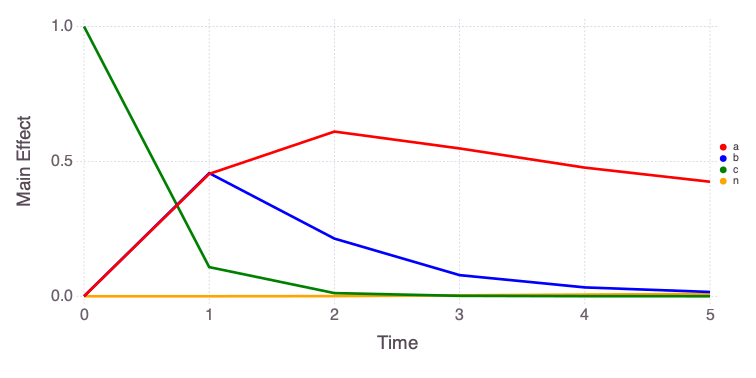

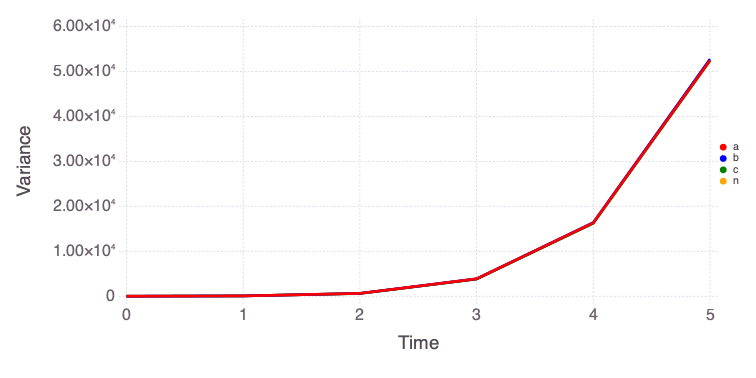

In [35]:
Mads.plotobsSAresults(md, saltelli_results)

The EFAST results are obtained as follows:

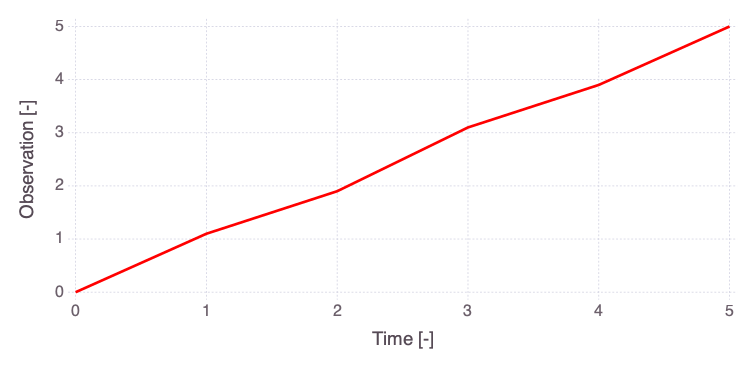

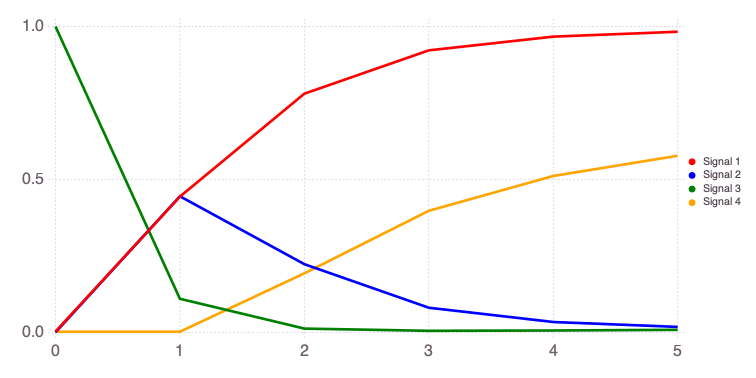

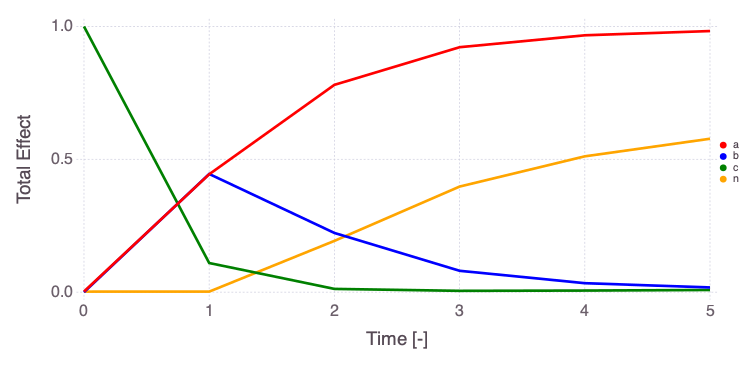

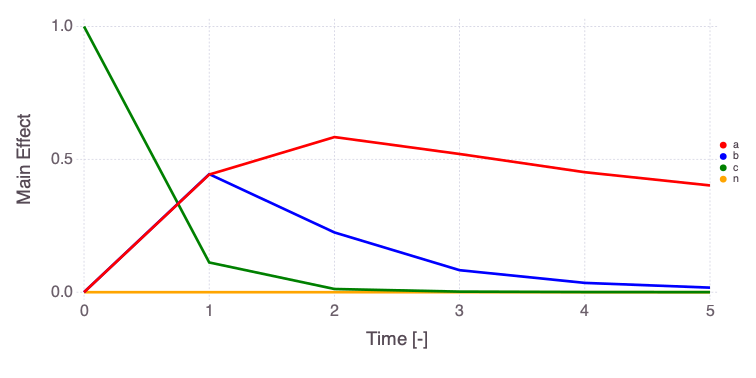

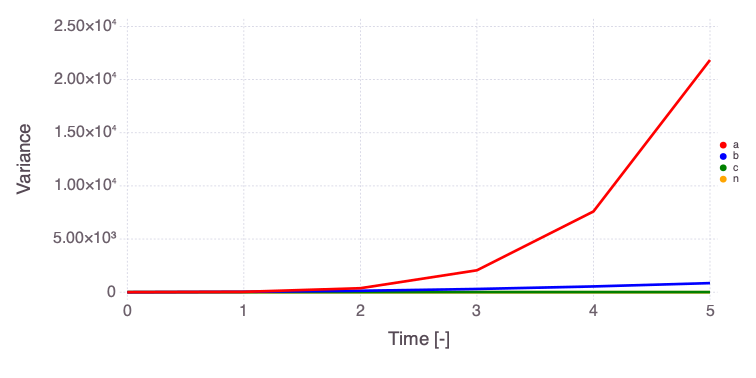

In [36]:
efastresult = Mads.efast(md, N=1000, seed=2016)
Mads.plotobsSAresults(md, efastresult, filename="sensitivity_efast.png", xtitle = "Time [-]", ytitle = "Observation [-]")

The differences in the `total` and `main` effect plots suggest correlations in the model parameters (which is also demonstrated by the `AffineInvariantMCMC` analyses above).

The figures also demonstrate that the parameter sensitivity to observations changes over time.

Based on the `total effect`, parameter `a` and `n` sensitivities generally increase with time.
Parameter `b` and `b` sensitivities generally decrease with time.

## Decision Analysis using Information-Gap Decision Theory

Define the Information-Gap Decision Theory horizons of uncertainty `h`:

In [37]:
h = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]



8-element Vector{Float64}:
 0.001
 0.01
 0.02
 0.05
 0.1
 0.2
 0.5
 1.0

Define the polynomial models to be explored:

In [38]:
models = ["y = a * t + c", "y = a * t^(1.1) + b * t + c", "y = a * t^n + b * t + c", "y = a * exp(t * n) + b * t + c"]

4-element Vector{String}:
 "y = a * t + c"
 "y = a * t^(1.1) + b * t + c"
 "y = a * t^n + b * t + c"
 "y = a * exp(t * n) + b * t + c"

Execute the infogap analyses, collect the obtained results, and produce a figure summarizing the results:

In [39]:
import Gadfly
import Colors
lmin = Vector{Any}(undef, 4)
lmax = Vector{Any}(undef, 4)
colors = ["blue", "red", "green", "orange"]
for i = 1:4
	min, max = Mads.infogap_jump_polynomial(model=i, plot=true, horizons=h, retries=10, maxiter=1000, verbosity=0, seed=2015)
	lmin[i] = Gadfly.layer(x=min, y=h, Gadfly.Geom.line, Gadfly.Theme(line_width=2Gadfly.pt, line_style=[:dash], default_color=Base.parse(Colors.Colorant, colors[i])))
	lmax[i] = Gadfly.layer(x=max, y=h, Gadfly.Geom.line, Gadfly.Theme(line_width=2Gadfly.pt, line_style=[:solid], default_color=Base.parse(Colors.Colorant, colors[i])))
end
f = Gadfly.plot(lmin..., lmax..., Gadfly.Guide.xlabel("o5"), Gadfly.Guide.ylabel("Horizon of uncertainty"), Gadfly.Guide.title("Opportuneness vs. Robustness"), Gadfly.Theme(highlight_width=0Gadfly.pt), Gadfly.Guide.manual_color_key("Models", models, colors))
Gadfly.draw(Gadfly.PNG("infogap_opportuneness_vs_robustness.png", 6Gadfly.inch, 4Gadfly.inch), f)

┌ Info: New seed: 2015
└ @ Mads /Users/vvv/.julia/dev/Mads/src/MadsHelpers.jl:462



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Min h = 0.001 OF = 4.998333281688344 par = [0.9993333197989149, 0.0016666826937701167]


Max h = 0.001 OF = 5.00166671833499 par = [1.0006666802044195, -0.001666682687108125]


Min h = 0.01 OF = 4.983333280036714 par = [0.9933333177282005, 0.016666691395710947]


Max h = 0.01 OF = 5.016666718990943 par = [1.0066666807443947, -0.016666684731030848]


Min h = 0.02 OF = 4.966666614342419 par = [0.9866666521256426, 0.033333353714205226]


Max h = 0.02 OF = 5.033333387019943 par = [1.0133333489146892, -0.03333335755350352]


Min h = 0.05 OF = 4.916666615311706 par = [0.9666666528982734, 0.08333335082033852]
Max h = 0.05 OF = 5.08333338580072 par = [1.0333333472115793, -0.08333335025717689]


Min h = 0.1 OF = 4.833333282661476 par = [0.9333333197717608, 0.16666668380267258]
Max h = 0.1 OF = 5.166666719675405 par = [1.0666666805654965, -0.16666668315207778]


Min h = 0.2 OF = 4.666666617013978 par = [0.8666666531305123, 0.333333351361417]
Max h = 0.2 OF = 5.3333333876552285 par = [1.133333347539164, -0.3333333500405913]


Min h = 0.5 OF = 4.166666620015298 par = [0.666666653134728, 0.8333333543416581]
Max h = 0.5 OF = 5.8333333916516725 par = [1.3333333485322296, -0.8333333510094758]


Min h = 1.0 OF = 3.333333291678896 par = [0.33333331979902153, 1.666666692683788]


Max h = 1.0 OF = 6.66666673165455 par = [1.6666666835343882, -1.666666686017392]


┌ Info: New seed: 2015
└ @ Mads /Users/vvv/.julia/dev/Mads/src/MadsHelpers.jl:462


Min h = 0.001 OF = 4.9960744454905965 par = [-0.03655198917957378, 1.0437989392240055, -0.008246956140052745]


Max h = 0.001 OF = 5.003925554522909 par = [0.036551989057392965, 0.9562010609257169, 0.008246956122525443]


Min h = 0.01 OF = 4.960745363330646 par = [-0.36551410869632334, 1.437982560318741, -0.08246845805988594]


Max h = 0.01 OF = 5.039254636799261 par = [0.3655141073877924, 0.5620174412841543, 0.08246845786044212]


Min h = 0.02 OF = 4.921490828175631 par = [-0.731027566617381, 1.8759643517308704, -0.16493679213714782]


Max h = 0.02 OF = 5.078509171873495 par = [0.7310275550438009, 0.12403566252037508, 0.1649367889027792]


Min h = 0.05 OF = 4.803727222947509 par = [-1.8275679184585027, 3.1899096986947266, -0.41234178651963727]
Max h = 0.05 OF = 5.196272777724391 par = [1.8275679123567241, -1.189909691219638, 0.41234178565241686]


Min h = 0.1 OF = 4.607454547104612 par = [-3.6551351873746936, 5.379818629776438, -0.8246834485881221]
Max h = 0.1 OF = 5.392545454245484 par = [3.655135175083979, -3.3798186147139266, 0.824683446810193]


Min h = 0.2 OF = 4.214909194737556 par = [-7.310269737140044, 9.759636506472651, -1.64936677598685]


Max h = 0.2 OF = 5.7850908074455605 par = [7.3102697046759735, -7.759636466764177, 1.6493667702921515]


Min h = 0.5 OF = 3.591684039656965 par = [-7.751158513274632, 10.000000041783382, -0.8850280664081923]


Max h = 0.5 OF = 6.49427721194079 par = [9.382981348214942, -10.000000044037646, 1.3871392608548654]


Min h = 1.0 OF = 2.6876583975888058 par = [-8.067223019985045, 10.000000062883482, 0.0672229701222594]


Max h = 1.0 OF = 7.44592953417183 par = [9.736303636511739, -10.000000065441785, 0.26369642586347747]


┌ Info: New seed: 2015
└ @ Mads /Users/vvv/.julia/dev/Mads/src/MadsHelpers.jl:462


Min h = 0.001 OF = 4.993999809993968 par = [-0.0001250040451789784, 1.0026250655869564, -0.0035000665302511625, 2.999997843315674]


Max h = 0.001 OF = 5.006000200041004 par = [0.00012500374313672267, 0.997374931285495, 0.0035000749793720805, 3.000000029507715]


Min h = 0.01 OF = 4.939999809729828 par = [-0.0012500039848518721, 1.0262500653481148, -0.03500006635146049, 2.999999811324717]


Max h = 0.01 OF = 5.060000190420172 par = [0.0012500039827685484, 0.9737499347289683, 0.035000066376460574, 2.9999998113247166]


Min h = 0.02 OF = 4.879999809436044 par = [-0.002500003917827296, 1.0525000650829668, -0.07000006615333457, 2.9999999206621957]


Max h = 0.02 OF = 5.120000190863952 par = [0.002500003913660588, 0.9474999350712004, 0.0700000662033339, 2.9999999206621952]


Min h = 0.05 OF = 4.699999809110879 par = [-0.006250003705588852, 1.1312500640011731, -0.17500006484468256, 2.9999999863618134]


Max h = 0.05 OF = 5.300000191636143 par = [0.006250003695269465, 0.8687499363840293, 0.1750000649694136, 2.99999998635084]


Min h = 0.1 OF = 4.399999807272094 par = [-0.012500003374736784, 1.2625000628015948, -0.35000006419023805, 3.000000008232852]


Max h = 0.1 OF = 5.600000194228184 par = [0.012500003353865882, 0.7374999379699614, 0.35000006443880427, 3.0000000082339633]


Min h = 0.2 OF = 3.7999998042537553 par = [-0.025000002708412933, 1.5250000602396283, -0.700000062415874, 3.000000019082813]


Max h = 0.2 OF = 6.20000019874704 par = [0.02500000266667985, 0.47499994130280493, 0.7000000629146885, 3.0000000190840956]


Min h = 0.5 OF = 1.999999795385952 par = [-0.06250000069969568, 2.3125000523306776, -1.7500000565793346, 3.000000025626925]


Max h = 0.5 OF = 8.000000212115324 par = [0.0625000005955181, -0.31250004847656593, 1.7500000578296342, 3.0000000256271333]


Min h = 1.0 OF = -1.0000002193334967 par = [-0.12499999734956149, 3.625000039098136, -3.5000000467297627, 3.000000027811915]


Max h = 1.0 OF = 11.000000234333372 par = [0.12499999714118018, -1.6250000313891586, 3.5000000492286207, 3.000000027812066]


┌ Info: New seed: 2015
└ @ Mads /Users/vvv/.julia/dev/Mads/src/MadsHelpers.jl:462


Min h = 0.001 OF = 4.93820509022155 par = [-1.991956463987334e-8, 1.001080524737567, -0.0020801343866858023, 2.9999999883894968]


Max h = 0.001 OF = 5.061794919720368 par = [1.991956366528757e-8, 0.9989194750922847, 0.002080134822476713, 3.000000029984543]


Min h = 0.01 OF = 4.382067676125225 par = [-1.9919025980225499e-7, 1.0108050472181263, -0.020801056118970217, 3.0000000258388377]


Max h = 0.01 OF = 5.617932323094888 par = [1.991902594702715e-7, 0.9891949528332155, 0.020801056167635203, 3.0000000258388377]


Min h = 0.02 OF = 3.7641372160181787 par = [-3.9837992109379617e-7, 1.0216100721965256, -0.0416020802659529, 3.0000000279194157]


Max h = 0.02 OF = 6.23586278242203 par = [3.983799204298235e-7, 0.9783899279061579, 0.041602080363282834, 3.0000000279194157]


Min h = 0.05 OF = 1.9103458356971257 par = [-9.959489049683935e-7, 1.0540251471317235, -0.10400515270690125, 3.0000000291677655]


Max h = 0.05 OF = 8.089654160403452 par = [9.959489033084791e-7, 0.945974853124985, 0.1040051529502259, 3.0000000291677655]


Min h = 0.1 OF = -1.1793064329087564 par = [-1.9918972144258892e-6, 1.1080502714651672, -0.20801027206863687, 3.000000028258382]


Max h = 0.1 OF = 11.179306457039136 par = [1.9918972081062344e-6, 0.8919497284896971, 0.2080102739284642, 3.0000000295838825]


Min h = 0.2 OF = -7.358611065908197 par = [-3.983793824341401e-6, 1.2161005218077126, -0.41602051491164094, 3.000000029791941]


Max h = 0.2 OF = 17.35861105031053 par = [3.98379381770175e-6, 0.7838994792191215, 0.41602051588494027, 3.000000029791941]


Min h = 0.5 OF = -25.896488521674833 par = [-9.959487073347952e-6, 1.5402506350898875, -1.0400496755102369, 2.999999728223722]


Max h = 0.5 OF = 35.896523990350396 par = [9.959483725387019e-6, 0.4597487460979546, 1.040051205638272, 3.000000022944347]


Min h = 1.0 OF = -56.79304787447036 par = [-1.9918966727663864e-5, 2.0805025200796528, -2.0801024466702493, 3.0000000299583918]


Max h = 1.0 OF = 66.79304780650143 par = [1.9918966693524435e-5, -0.08050251512076644, 2.080102451967674, 3.0000000299999843]


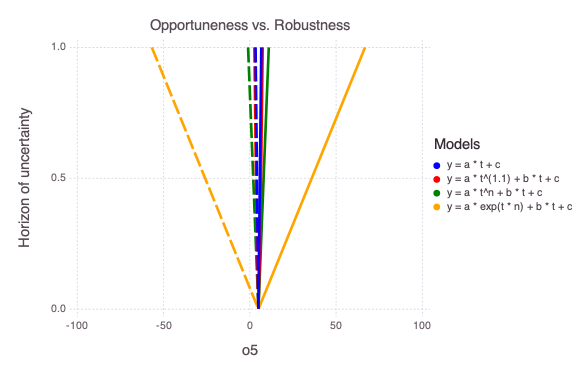

In [40]:
Mads.display("infogap_opportuneness_vs_robustness.png")

The figure above compares the model `opportuneness` (dashed lines) vs model `robustness` (solid lines) for different infogap horizons of uncertainty `h` and different models (different colors).

The model `opportuneness` defines that the things might get better than expected (i.e., observation at dimensionless time 5 `o5` can get lower than expected).

The model `robustness` defines that things might get worse than expected (i.e., observation at dimensionless time 5 `o5` can get higher than expected).

Based on both the model `opportuneness` and model `robustness`, the last model is the most complex and can bring the most surprises.
The first model is the simplest and produces the lower level of surprises.

In terms of model selection, the simplest model is the best. However, the alternative models (if they capture all the conceptual model uncertainties) represent how much things can get worse/better within the horizon of uncertainty.